Explained Variance Ratio:
[0.25996312 0.20964987 0.13268441 0.11218552 0.09651554 0.08811459
 0.06909358]


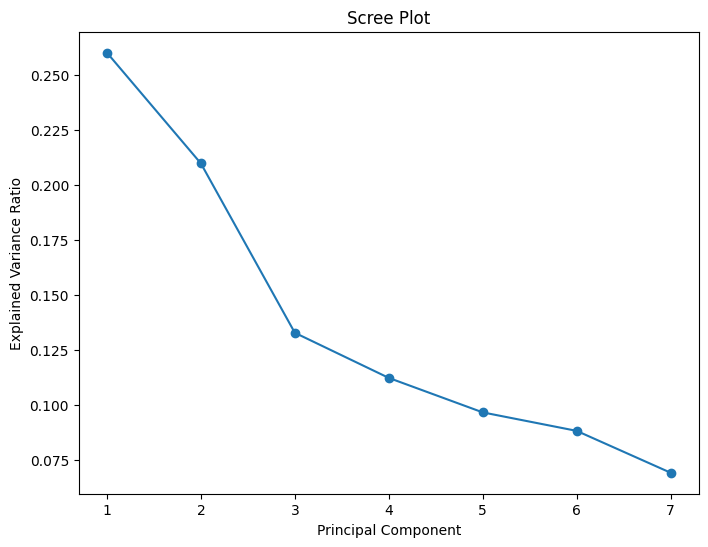

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV

# Clean data
data_train = pd.read_csv('titanic_800.csv', quotechar='"')

mean_cols = data_train.select_dtypes(include=['number']).columns
data_train[mean_cols] = data_train[mean_cols].fillna(data_train[mean_cols].mean())

data_train['Cabin'] = data_train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'N')

cols_drop = ['PassengerId', 'Name', 'Ticket']
data_train.drop(cols_drop, axis=1, inplace=True)

# Label encode categorical features 
le = LabelEncoder()
data_train['Sex'] = le.fit_transform(data_train['Sex'])
data_train['Cabin'] = le.fit_transform(data_train['Cabin'])
data_train['Embarked'] = le.fit_transform(data_train['Embarked'])

# Split data
X = data_train.drop('Survived', axis=1)
y = data_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA
pca = PCA(n_components=7)  
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

# Explained Variance
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

#df_loadings = pd.DataFrame(pca.components_.T, 
#                           columns=['PC1', 'PC2', 'PC3'], 
#                           index=X.columns)
#print(df_loadings)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1)) 
plt.show()

In [4]:
def evaluate_model(model, X_test, y_test):
    """Evaluates a model and prints performance metrics"""
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)  
    print("Confusion Matrix:\n", cm)

# could use arrays instead of range if performance is an issue
rf_param_grid = {
    'n_estimators': range(1, 101),
    'max_depth': range(2, 10),
}
gb_param_grid = {
    'n_estimators': range(1, 101),
    'max_depth': range(2, 10),
    'learning_rate': [0.3, 0.2, 0.1]
}

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1) 
rf_grid_search.fit(X_train_pca, y_train)  

print("*** Random Forest Gridsearch Results ***")
print("Best Parameters:", rf_grid_search.best_params_)
print("Best Accuracy:", rf_grid_search.best_score_)

# Retrain the model with the best parameters 
best_rf_model = RandomForestClassifier(**rf_grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train_pca, y_train) 

print("*** Random Forest Results ***")
evaluate_model(best_rf_model, X_test_pca, y_test)

# Gradient Boosted Tree
gb_model = GradientBoostingClassifier(random_state=42) 
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)  
gb_grid_search.fit(X_train_pca, y_train)  

print("*** Gradient Boosted Tree Gridsearch Results ***") 
print("Best Parameters:", gb_grid_search.best_params_)
print("Best Accuracy:", gb_grid_search.best_score_)

# Retrain the Gradient Boosting model with the best parameters
best_gb_model = GradientBoostingClassifier(**gb_grid_search.best_params_, random_state=42)  
best_gb_model.fit(X_train_pca, y_train) 

print("*** Gradient Boosted Tree Results ***")
evaluate_model(best_gb_model, X_test_pca, y_test)

*** Random Forest Gridsearch Results ***
Best Parameters: {'max_depth': 6, 'n_estimators': 36}
Best Accuracy: 0.8147375670864033
*** Random Forest Results ***
Accuracy: 0.8083333333333333
Precision: 0.7804878048780488
Recall: 0.6956521739130435
F1-Score: 0.735632183908046
Confusion Matrix:
 [[65  9]
 [14 32]]
*** Gradient Boosted Tree Gridsearch Results ***
Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 53}
Best Accuracy: 0.8059139994542123
*** Gradient Boosted Tree Results ***
Accuracy: 0.7916666666666666
Precision: 0.7692307692307693
Recall: 0.6521739130434783
F1-Score: 0.7058823529411765
Confusion Matrix:
 [[65  9]
 [16 30]]
